#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [3]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, EfficientNetB5, DenseNet121, MobileNetV2, NASNetMobile
from keras.models import Model, Sequential
from keras.layers import concatenate, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from tqdm import tqdm

##Define runtime

In [4]:
!pip install ipython-autotime
%load_ext autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 378 µs (started: 2024-08-07 15:36:04 +00:00)


##Define GPU usage

In [5]:
# Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time: 280 µs (started: 2024-08-07 15:36:04 +00:00)


#DATA PREPARATION

##Get and Import dataset

In [ ]:
# !gdown "1Ebju7n2W8WoWSFSPouDfbJcaW47Nozgv"
# !unzip "/content/ISIC_2019_Challenge_Dataset.zip"

time: 346 µs (started: 2024-08-05 06:33:23 +00:00)


In [ ]:
# !gdown "1b-NZohmAAwhtZ-81EIt5bCI-c_3u-2jW"
# !gdown "1W3PE0W183h0nXW4ISSzW_aMZ4MWuDwhx"
# !gdown "1DQdofCumMkc8oGiHePB0sdMLMopXfvx-"
# !gdown "1FRM1CPVjVFxWLbZh242NTzR8L662DQ2e"
# !gdown "1T24VIj4GGyKv_ioSuOlz1zp08emXKXXE"

time: 351 µs (started: 2024-08-05 07:10:50 +00:00)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MASTER 1/Internship/ICT Lab/WORKSPACE/data/ISIC_2019/'
# data_dir = '/content'
# data_dir = '/content/drive/MyDrive/WORKSPACE/data/ISIC_2019'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

Mounted at /content/drive
time: 24.8 s (started: 2024-08-07 15:36:04 +00:00)


###Meta-data

In [7]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 4.92 s (started: 2024-08-07 15:36:29 +00:00)


In [8]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 1.03 s (started: 2024-08-07 15:36:34 +00:00)


In [9]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 1.02 s (started: 2024-08-07 15:36:35 +00:00)


###Meta-data information

In [10]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 30.4 ms (started: 2024-08-07 15:36:36 +00:00)


In [11]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 15.4 ms (started: 2024-08-07 15:36:36 +00:00)


In [12]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 14.8 ms (started: 2024-08-07 15:36:36 +00:00)


In [13]:
def print_unique_counts(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    unique_counts = df.nunique()
    print("\nUnique entries in each column:")
    for col in unique_counts.index:
        print(f"- {col}: {unique_counts[col]}")

# Now use the function for each dataframe
print_unique_counts(train_metadata, 'Train Metadata')
print_unique_counts(train_groundtruth, 'Train Groundtruth')
print_unique_counts(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Unique entries in each column:
- image: 25331
- age_approx: 18
- anatom_site_general: 8
- lesion_id: 11847
- sex: 2

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Unique entries in each column:
- image: 25331
- MEL: 2
- NV: 2
- BCC: 2
- AK: 2
- BKL: 2
- DF: 2
- VASC: 2
- SCC: 2
- UNK: 1

----------------------------------------
TEST METADATA
----------------------------------------

Unique entries in each column:
- image: 8238
- age_approx: 18
- anatom_site_general: 7
- sex: 2
time: 68.9 ms (started: 2024-08-07 15:36:36 +00:00)


In [14]:
# train_metadata['anatom_site_general'].unique()

time: 203 µs (started: 2024-08-07 15:36:36 +00:00)


##Data Analysis

###Meta-data describe

In [ ]:
def describe_and_check_nulls(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    print("\nDescription:")
    print(df.describe(include='all'))

    print("\nNull Values:")
    null_values = df.isnull().sum()
    print(null_values)

    print("\nPercentage of Null Values:")
    print(null_values / len(df) * 100)

# Now use the function for each dataframe
describe_and_check_nulls(train_metadata, 'Train Metadata')
describe_and_check_nulls(train_groundtruth, 'Train Groundtruth')
describe_and_check_nulls(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Description:
               image    age_approx anatom_site_general    lesion_id    sex
count          25331  24894.000000               22700        23247  24947
unique         25331           NaN                   8        11847      2
top     ISIC_0000000           NaN      anterior torso  BCN_0001728   male
freq               1           NaN                6915           31  13286
mean             NaN     54.028481                 NaN          NaN    NaN
std              NaN     18.130971                 NaN          NaN    NaN
min              NaN      0.000000                 NaN          NaN    NaN
25%              NaN     40.000000                 NaN          NaN    NaN
50%              NaN     55.000000                 NaN          NaN    NaN
75%              NaN     70.000000                 NaN          NaN    NaN
max              NaN     85.000000                 NaN         

In [ ]:
# train_metadata.describe(include='all')
# train_groundtruth.describe(include='all')
# test_metadata.describe(include='all')

# print("\ntrain_metadata")
# print(train_metadata.isnull().sum())
# print("\ntrain_groundtruth")
# print(train_groundtruth.isnull().sum())
# print("\ntest_metadata")
# print(test_metadata.isnull().sum())

time: 479 µs (started: 2024-08-03 16:36:56 +00:00)


###Plot data

####Define and describe meta-data's columns

In [ ]:
# List of dataframes
dfs = [train_metadata, train_groundtruth, test_metadata]
df_names = ['train_metadata', 'train_groundtruth', 'test_metadata']

time: 862 µs (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image', 'anatom_site_general', 'sex']
numerical_columns = ['age_approx']


time: 694 µs (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Describe each dataframe
def describe_columns(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print("\nNumerical Columns:")
    for col in numerical_cols:
        print(f"- {col}")

    print("\nCategorical Columns:")
    for col in categorical_cols:
        print(f"- {col}")

# Describe each dataframe
describe_columns(train_metadata, 'Train Metadata')
describe_columns(train_groundtruth, 'Train Groundtruth')
describe_columns(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- lesion_id
- sex

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Numerical Columns:
- MEL
- NV
- BCC
- AK
- BKL
- DF
- VASC
- SCC
- UNK

Categorical Columns:
- image

----------------------------------------
TEST METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- sex
time: 63.6 ms (started: 2024-08-03 16:36:57 +00:00)


####Missing values

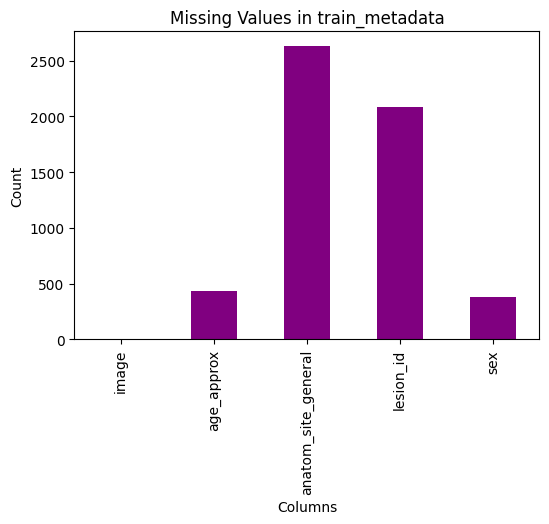

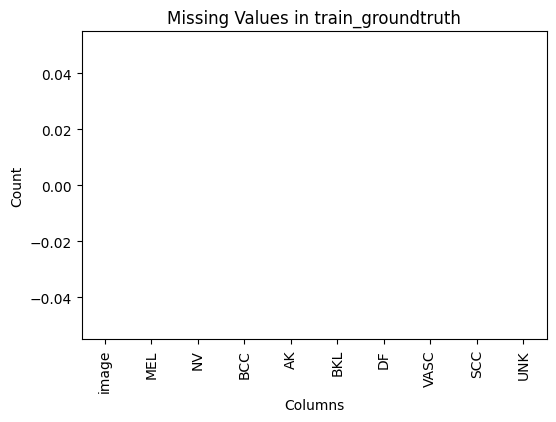

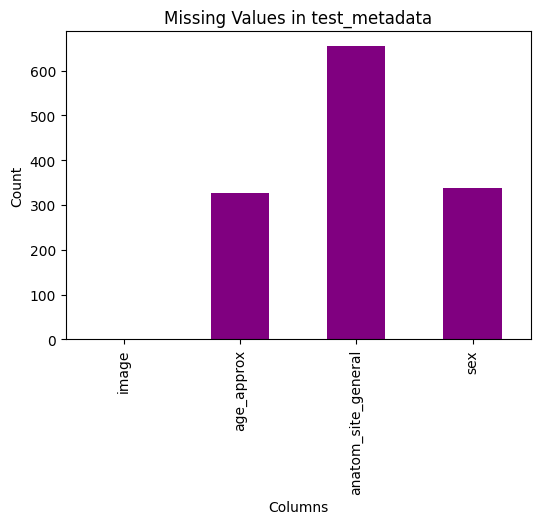

time: 3.37 s (started: 2024-08-03 16:36:57 +00:00)


In [ ]:
# Loop through dataframes
for i, df in enumerate(dfs):
    # Calculate missing values
    missing_values = df.isnull().sum()

    # Plot missing values
    plt.figure(figsize=(6, 4))
    missing_values.plot(kind='bar', color='purple')
    plt.title('Missing Values in ' + df_names[i])
    plt.ylabel('Count')
    plt.xlabel('Columns')
    plt.show()


####Training-Metadata distribution

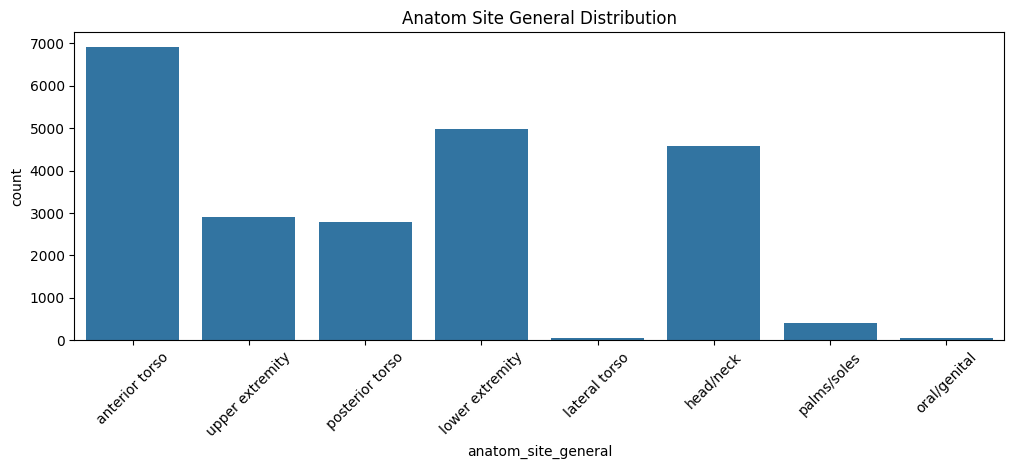

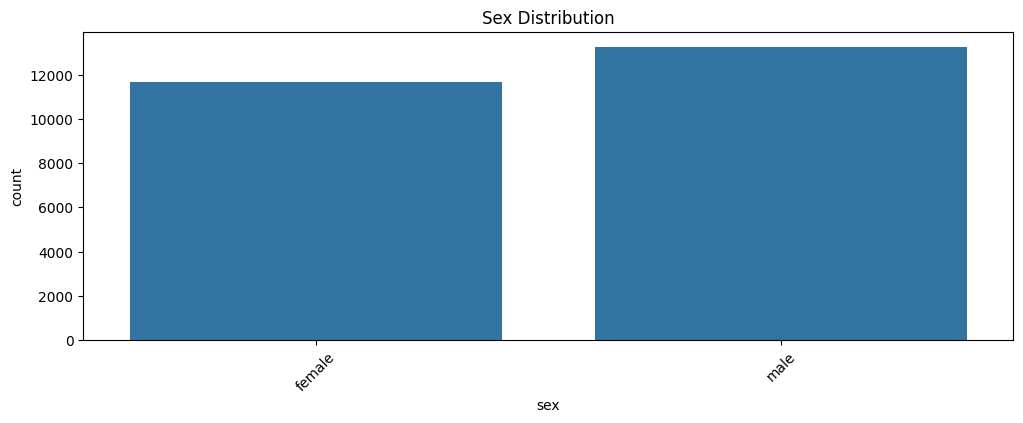

time: 2.54 s (started: 2024-08-03 16:37:00 +00:00)


In [ ]:
# Function to plot value counts for a given column
def plot_value_counts(data, column, title, figsize=(12, 4), rotation=45):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=column)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

# List of categorical columns to plot
categorical_columns_grt = ['anatom_site_general', 'sex']
# categorical_columns_grt = ['anatom_site_general', 'sex', 'lesion_id', 'image']

# Plot value counts for each categorical column
for column in categorical_columns_grt:
    plot_value_counts(train_metadata, column, f'{column.replace("_", " ").title()} Distribution')

# Plot value counts for lesion_id and image if needed
# plot_value_counts(train_metadata, 'lesion_id', 'Lesion ID Distribution', figsize=(16, 4))
# plot_value_counts(train_metadata, 'image', 'Image Name Distribution', figsize=(16, 4))

####Training_Groundtruth distribution

<ipython-input-22-57af30f33fcc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')


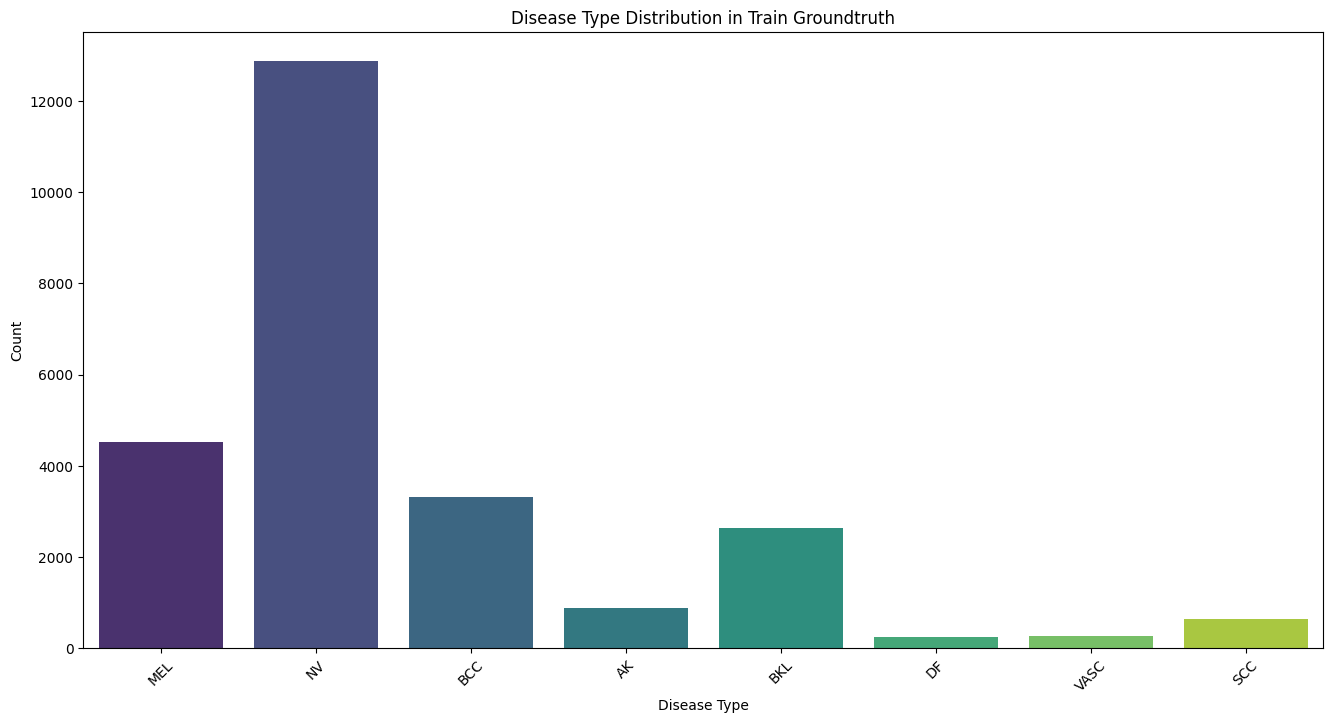

time: 1.64 s (started: 2024-08-03 16:37:03 +00:00)


In [ ]:
# Define columns to plot (excluding 'image' and 'UNK')
disease_type = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Sum up the counts of each class
disease_type_counts = train_groundtruth[disease_type].sum()

# Convert to DataFrame for easier plotting
disease_type_counts_df = pd.DataFrame(disease_type_counts).reset_index()
disease_type_counts_df.columns = ['Disease Type', 'Count']

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')
plt.title('Disease Type Distribution in Train Groundtruth')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


###Data Analysis for Relationship among variables

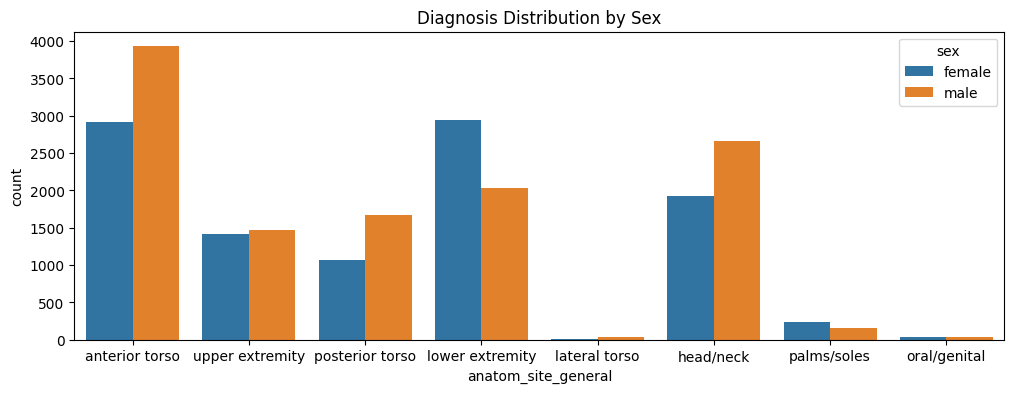

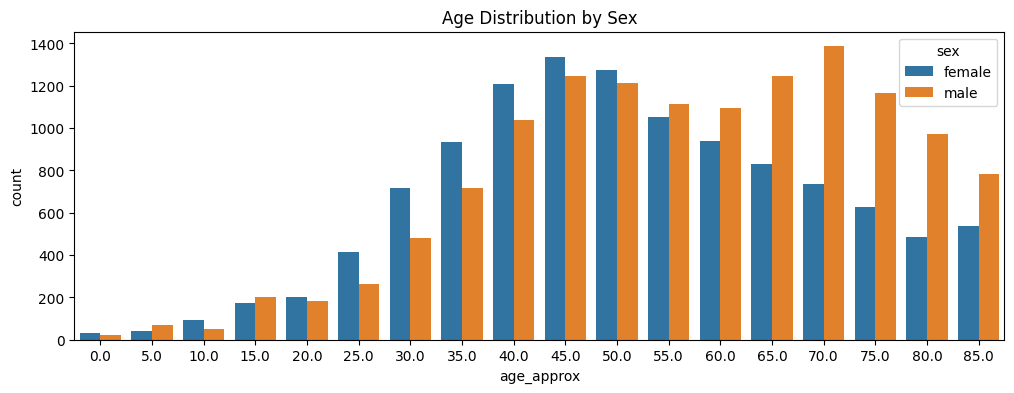

time: 4.38 s (started: 2024-08-03 16:37:04 +00:00)


In [ ]:
# Visualizing relationships between anatom_site_general and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='anatom_site_general', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

# Visualizing relationships between age_approx and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

In [ ]:
# Merge the metadata and groundtruth dataframes on the 'image' column
combined_df = pd.merge(train_metadata, train_groundtruth, on='image')

# Melt the dataframe to have disease types as a single column
melted_df = pd.melt(combined_df, id_vars=['image', 'sex', 'age_approx', 'anatom_site_general'], value_vars=disease_type)

# Filter out rows where value is 0 (i.e., the disease type is not present)
filtered_df = melted_df[melted_df['value'] == 1]

time: 257 ms (started: 2024-08-03 16:37:09 +00:00)


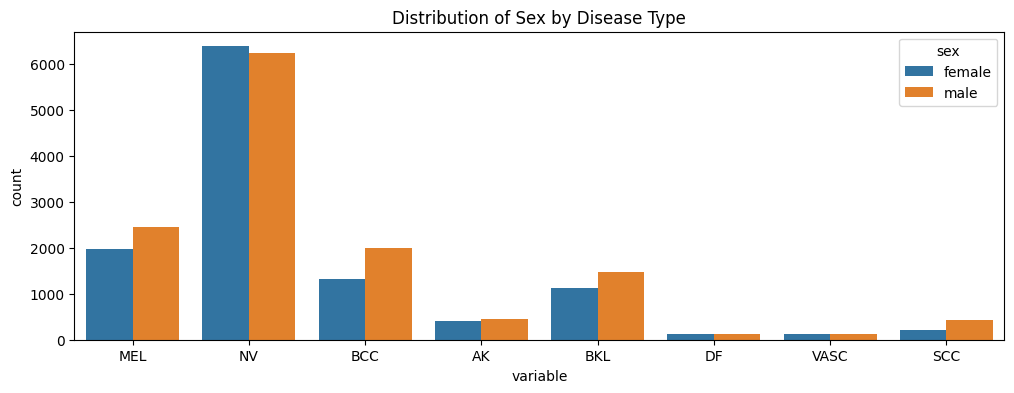

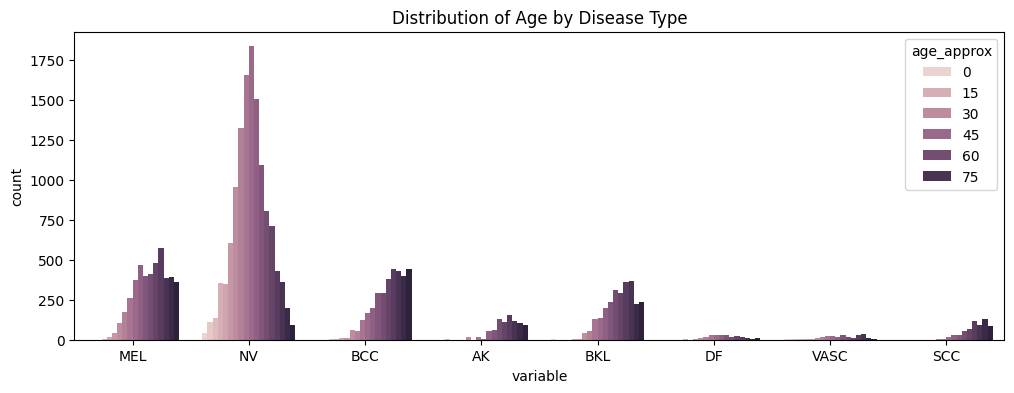

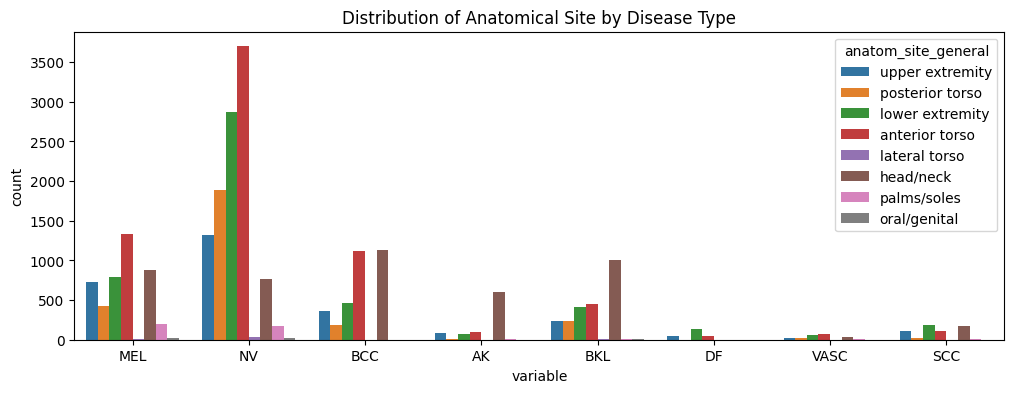

time: 5.39 s (started: 2024-08-03 16:37:09 +00:00)


In [ ]:
# Plot the distribution of 'sex' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='sex')
plt.title('Distribution of Sex by Disease Type')
plt.show()

# Plot the distribution of 'age_approx' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='age_approx')
plt.title('Distribution of Age by Disease Type')
plt.show()

# Plot the distribution of 'anatom_site_general' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='anatom_site_general')
plt.title('Distribution of Anatomical Site by Disease Type')
plt.show()

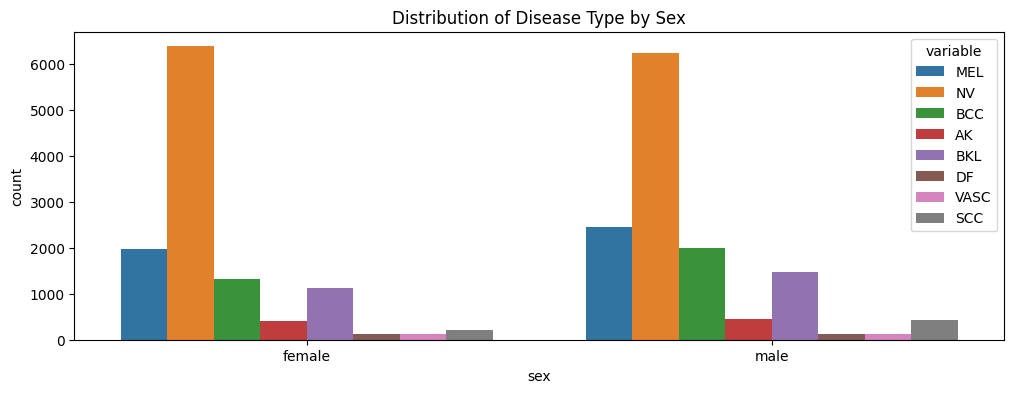

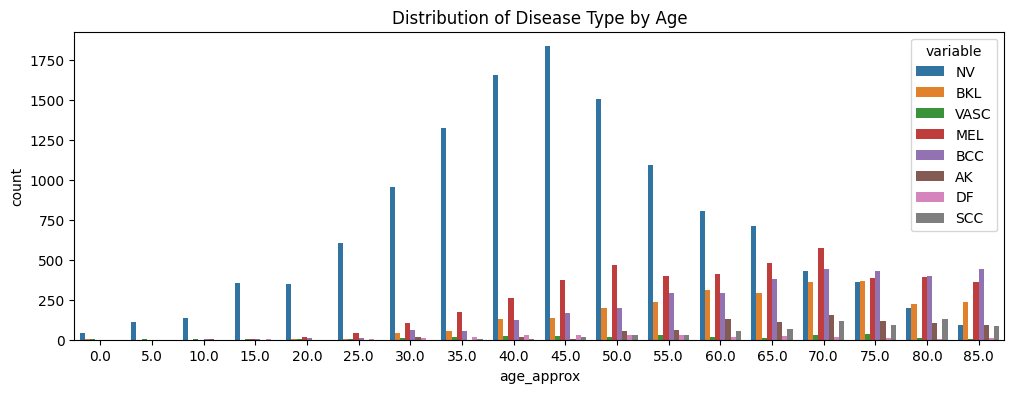

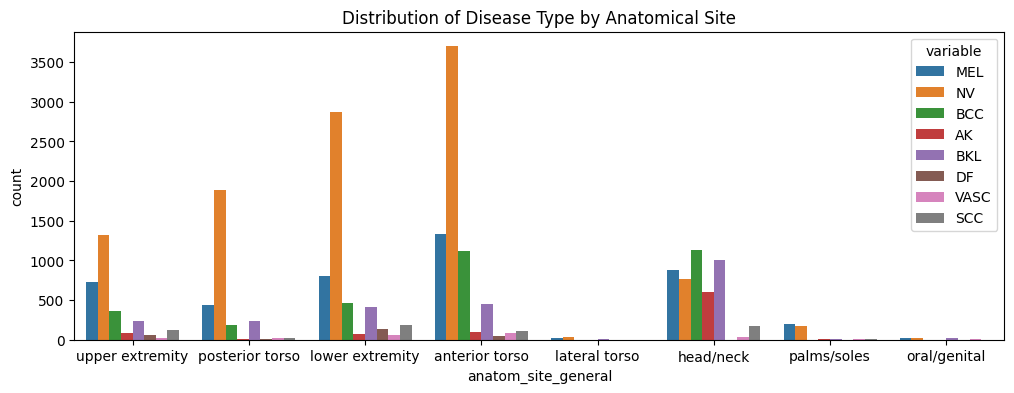

time: 4.16 s (started: 2024-08-03 16:37:14 +00:00)


In [ ]:
# Plot the distribution of disease type by 'sex'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='sex', hue='variable')
plt.title('Distribution of Disease Type by Sex')
plt.show()

# Plot the distribution of disease type by 'age_approx'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='age_approx', hue='variable')
plt.title('Distribution of Disease Type by Age')
plt.show()

# Plot the distribution of disease type by 'anatom_site_general'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='anatom_site_general', hue='variable')
plt.title('Distribution of Disease Type by Anatomical Site')
plt.show()


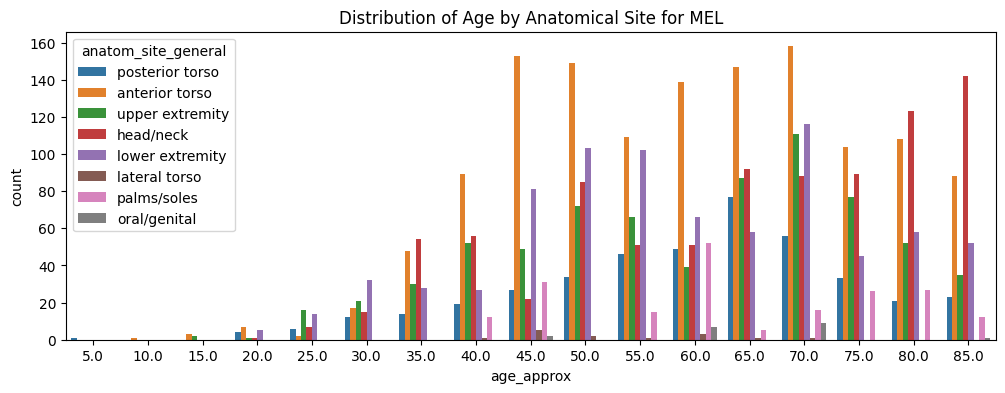

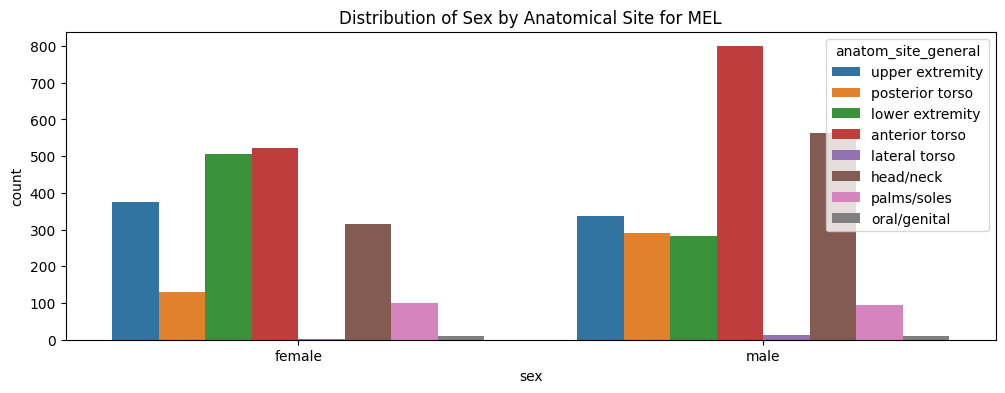

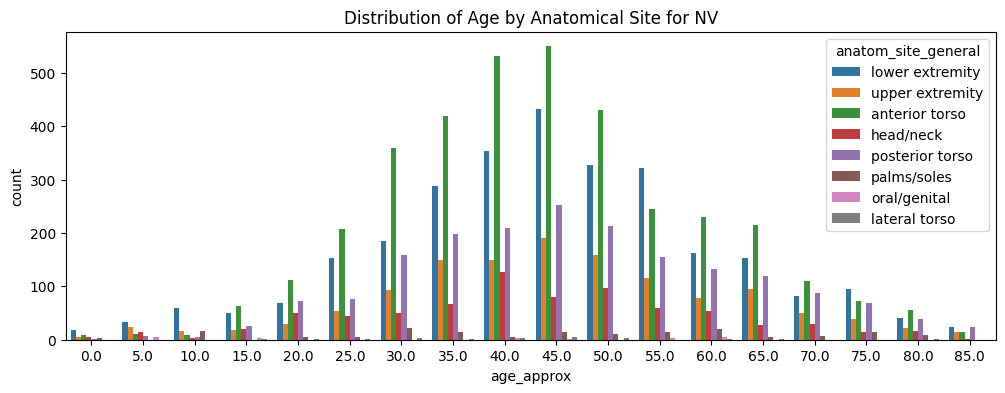

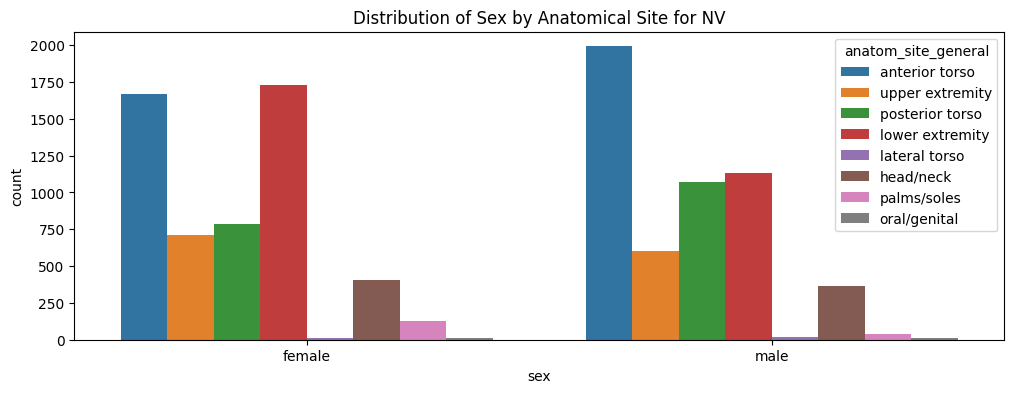

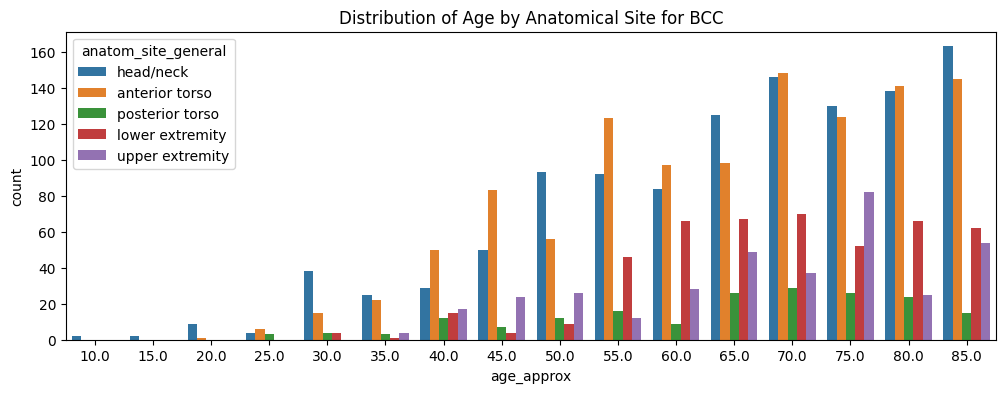

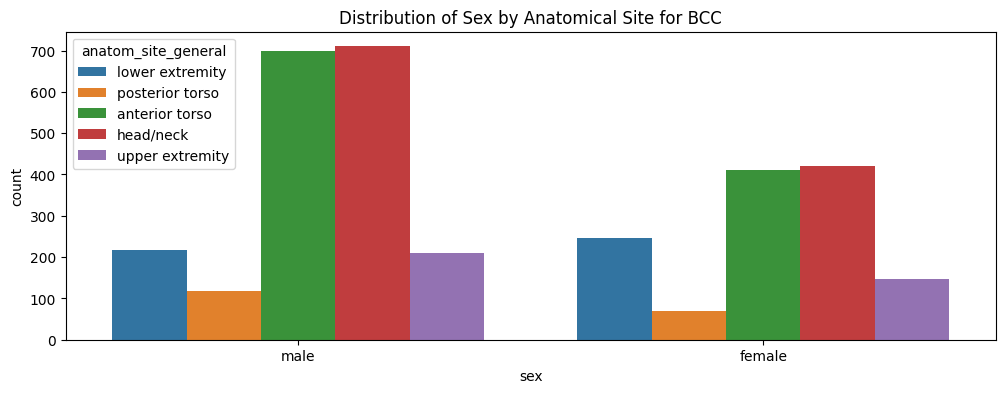

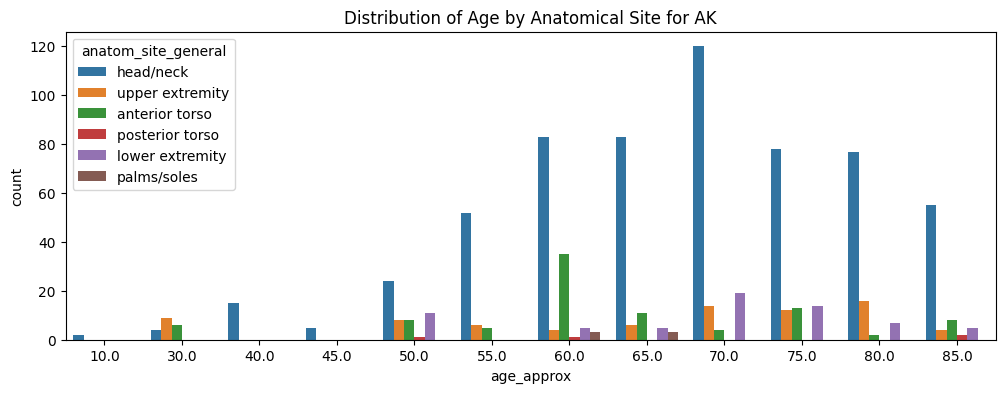

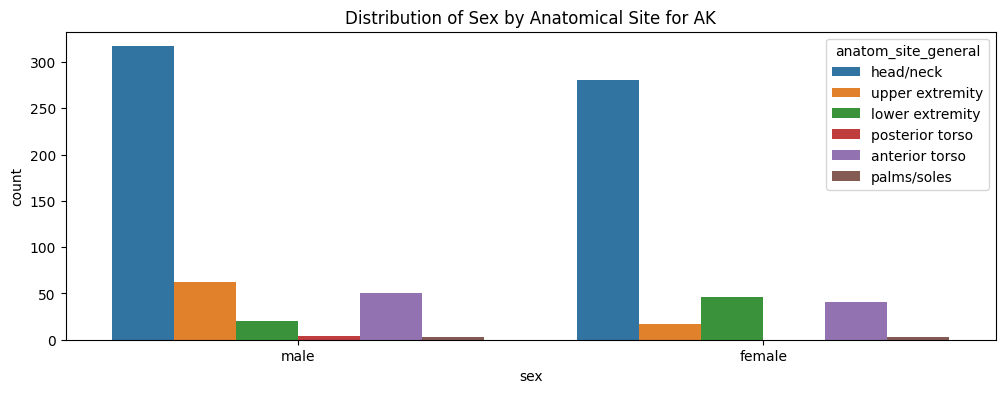

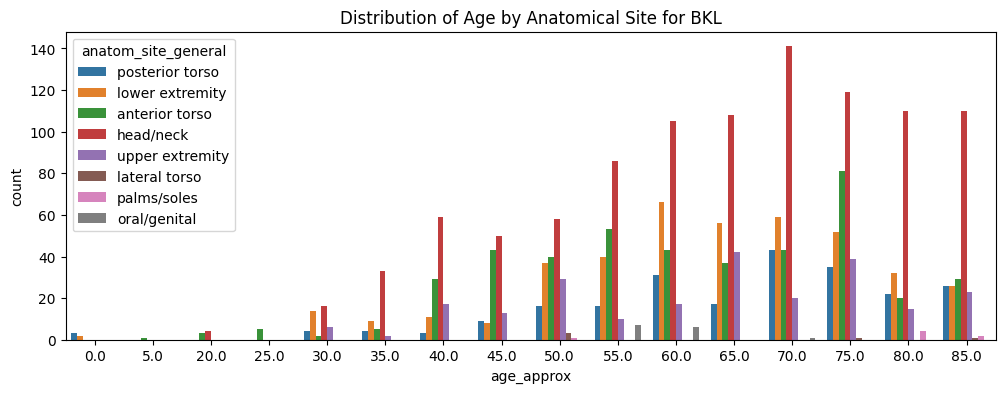

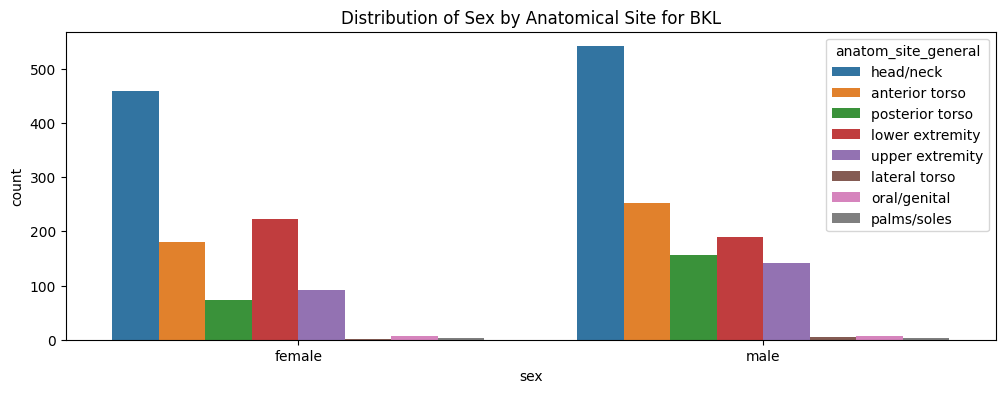

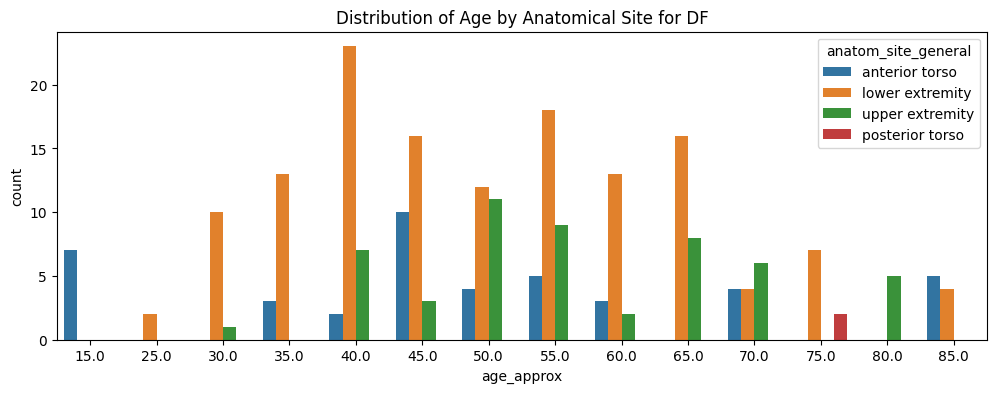

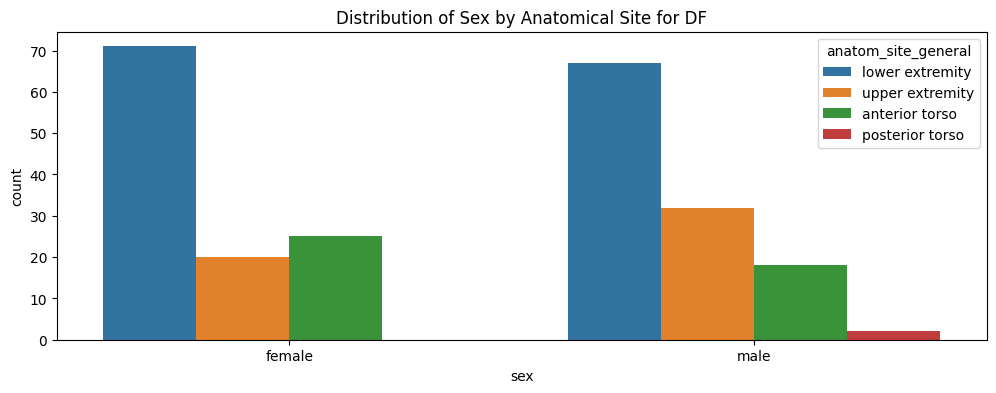

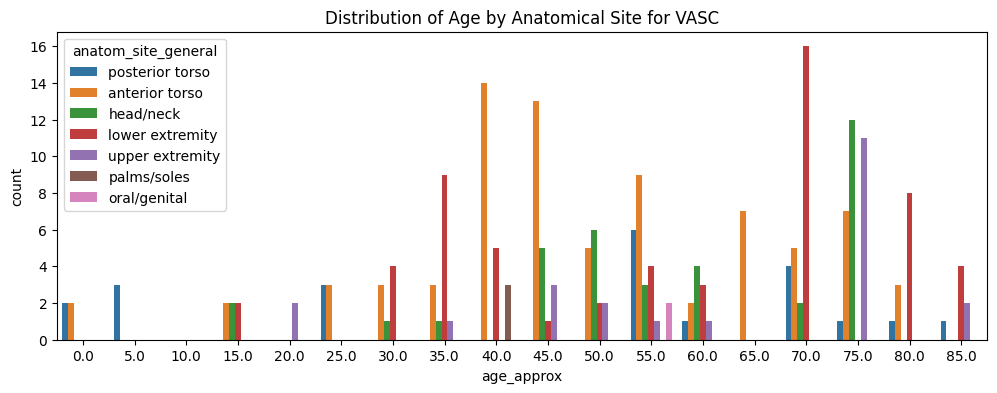

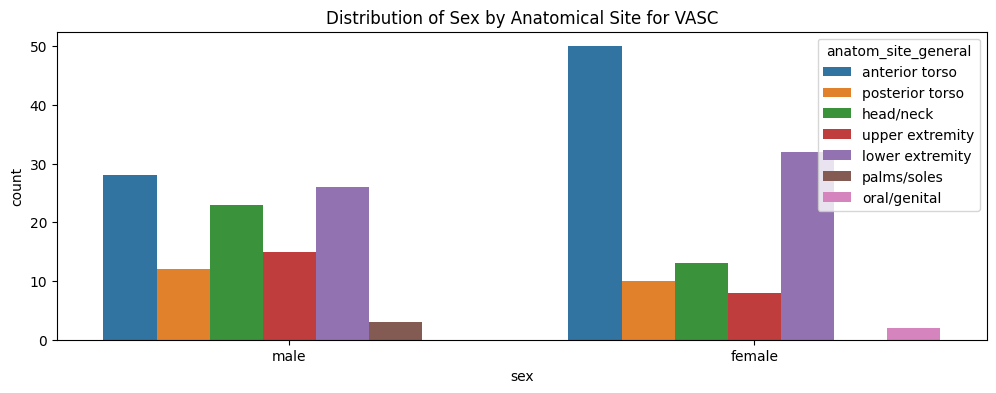

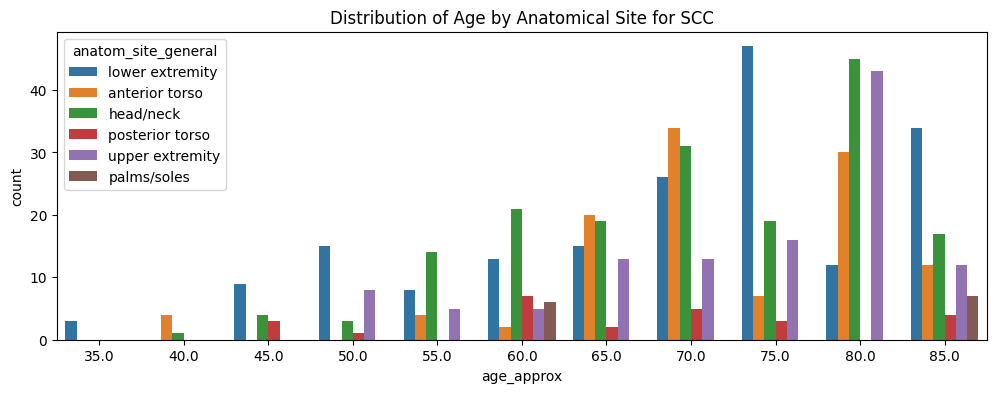

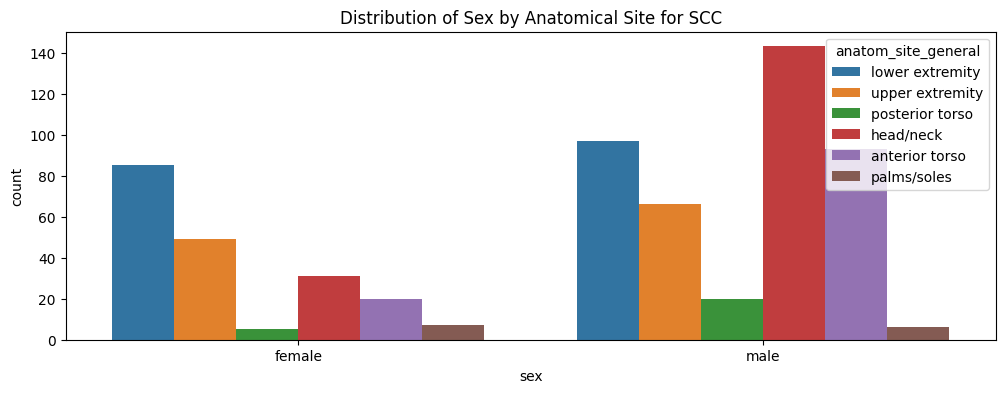

time: 22.5 s (started: 2024-08-03 16:37:19 +00:00)


In [ ]:
# Loop through each disease type
for disease in disease_type:
    # Create a subset of the dataframe for the current disease type
    subset_df = combined_df[combined_df[disease] == 1]

    # Plot the distribution of 'age_approx' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='age_approx', hue='anatom_site_general')
    plt.title(f'Distribution of Age by Anatomical Site for {disease}')
    plt.show()

    # Plot the distribution of 'sex' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='sex', hue='anatom_site_general')
    plt.title(f'Distribution of Sex by Anatomical Site for {disease}')
    plt.show()


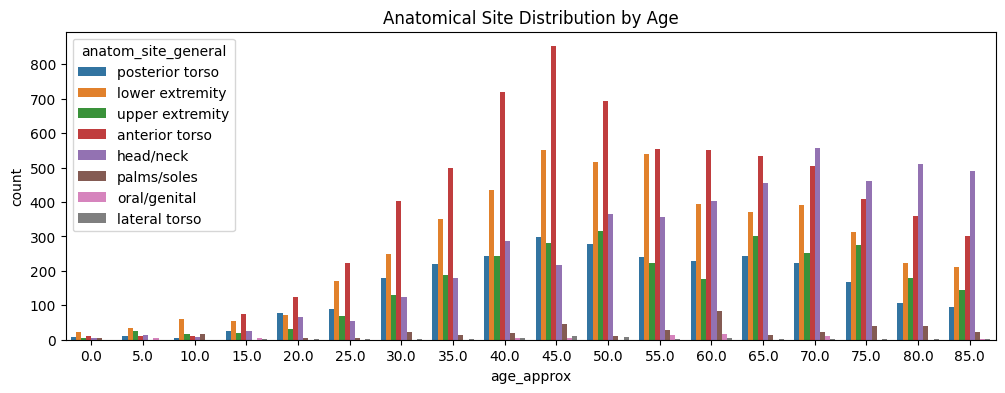

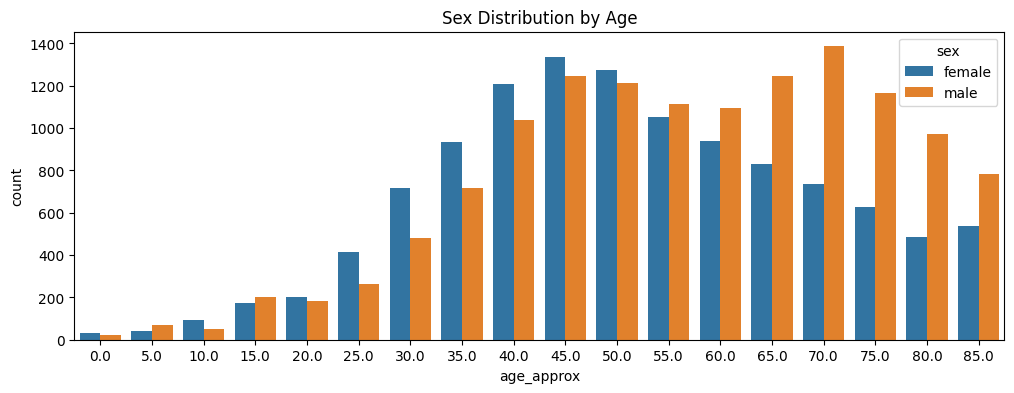

time: 1.47 s (started: 2024-08-03 16:37:41 +00:00)


In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='anatom_site_general')
plt.title('Anatomical Site Distribution by Age')
plt.show()

# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Sex Distribution by Age')
plt.show()

##DATA PREPROCESSING

###Original data information

In [15]:
train_metadata.info()
print()
train_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB



,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


time: 106 ms (started: 2024-08-07 15:36:36 +00:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [16]:
print(train_metadata.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 944 µs (started: 2024-08-07 15:36:36 +00:00)


In [17]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 70.4 ms (started: 2024-08-07 15:36:36 +00:00)


In [18]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 78.8 ms (started: 2024-08-07 15:36:36 +00:00)


In [19]:
for col in train_metadata_pp.columns:
  print(f'{col}: {train_metadata_pp[col].unique()}\n')

Image_Id: ['ISIC_0012653_downsampled' 'ISIC_0012654_downsampled'
 'ISIC_0012655_downsampled' ... 'ISIC_0073249' 'ISIC_0073251'
 'ISIC_0073254']

Age: [50 30 35 45 20 40 75 25 70 60 55 65 80 85 15 10  5  0]

Region_Of_Disease: ['posterior torso' 'lower extremity' 'upper extremity' 'head/neck'
 'anterior torso' 'lateral torso' 'palms/soles' 'oral/genital']

Lesion_Id: ['MSK4_0011169' 'MSK4_0011170' 'MSK4_0011171' ... 'BCN_0002147'
 'BCN_0001946' 'BCN_0001014']

Sex: ['female' 'male']

Disease_Type: ['NV' 'BKL' 'MEL' 'DF' 'SCC' 'BCC' 'VASC' 'AK']

Presence: [1.]

Diagnosis: ['Melanocytic Nevi' 'Benign Keratosis-Like Lesions' 'Melanoma'
 'Dermatofibroma' 'Squamous Cell Carcinoma' 'Basal Cell Carcinoma'
 'Vascular Lesions' 'Actinic Keratoses']

time: 42 ms (started: 2024-08-07 15:36:36 +00:00)


In [20]:
train_metadata_pp.info()
print()
train_metadata_pp

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB



,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 319 ms (started: 2024-08-07 15:36:36 +00:00)


###Get images data

finish preprocessing

In [22]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...


time: 6.64 s (started: 2024-08-07 15:38:52 +00:00)


In [23]:
train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42) # remove this line for full dataset
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 19360 to 7033
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           5000 non-null   object 
 1   Age                5000 non-null   int64  
 2   Region_Of_Disease  5000 non-null   object 
 3   Lesion_Id          5000 non-null   object 
 4   Sex                5000 non-null   object 
 5   Disease_Type       5000 non-null   object 
 6   Presence           5000 non-null   float64
 7   Diagnosis          5000 non-null   object 
 8   Image_path         5000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 390.6+ KB
time: 44.9 ms (started: 2024-08-07 15:38:58 +00:00)


###Correctting image paths

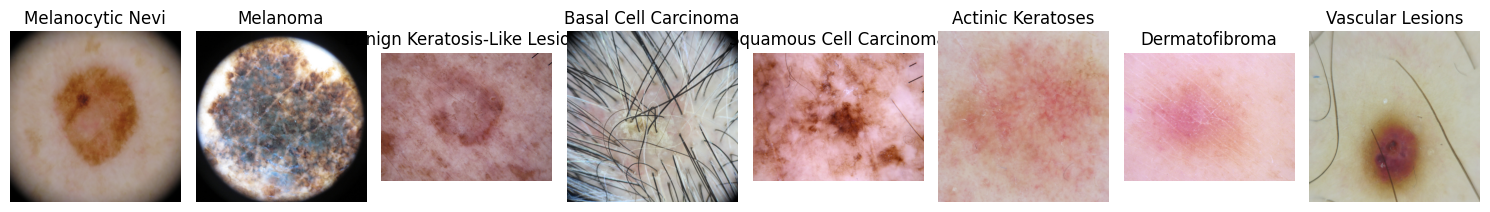

time: 19 s (started: 2024-08-07 15:38:58 +00:00)


In [24]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Prepare data for training process

###Label Encoder

In [25]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 7.63 ms (started: 2024-08-07 15:39:17 +00:00)


###Augment and transfrom dataset

In [26]:
# Data augmentation and transformation
transform = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

time: 393 µs (started: 2024-08-07 15:39:17 +00:00)


###Split data

In [27]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4000
Validation set size: 500
Test set size: 500
time: 18.1 ms (started: 2024-08-07 15:39:17 +00:00)


###Balancing dataset

In [28]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 14616
time: 23.2 ms (started: 2024-08-07 15:39:17 +00:00)


###Custom dataset class

In [29]:
# Data augmentation and transformation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_resampled,
    directory=None,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Example of iterating through the data generator and printing results
for images, labels in train_generator:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break  # Print only the first batch


Found 14616 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32, 8)
time: 32.8 s (started: 2024-08-07 15:39:17 +00:00)


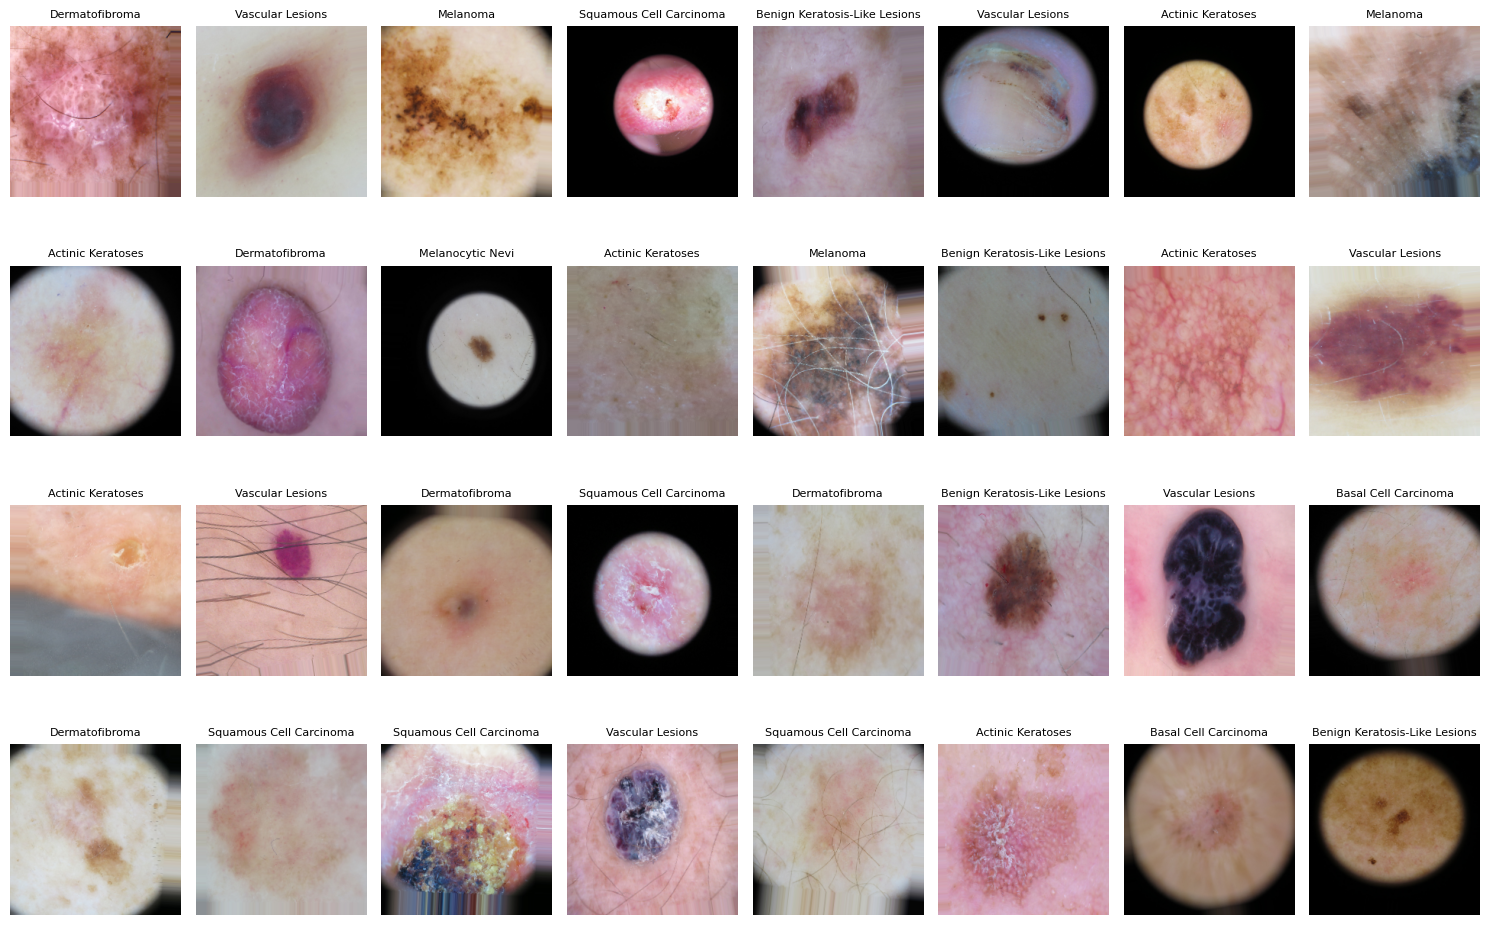

time: 31.3 s (started: 2024-08-07 15:39:50 +00:00)


In [30]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)

        img = images[i]  # Images are already in the correct format
        plt.imshow(img)
        plt.axis('off')

        label = np.argmax(labels[i])  # Get the index of the highest value in the one-hot encoded label
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(train_generator)

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)


##Model functionalities

###Load pre-trained and construct models

####Load pretrained models

In [31]:
# Define pre-trained model
def create_model(model_name, num_classes):
    if model_name == 'resnet50v2':
        base_model = ResNet50V2(weights='imagenet', include_top=False)
    elif model_name == 'efficientnet':
        base_model = EfficientNetB5(weights='imagenet', include_top=False)
    elif model_name == 'densenet':
        base_model = DenseNet121(weights='imagenet', include_top=False)
    elif model_name == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False)
    elif model_name == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50v2', 'efficientnet', 'densenet', 'mobilenetv2', or 'nasnetmobile'.")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

time: 975 µs (started: 2024-08-07 15:40:22 +00:00)


####Custom model

###Training activities

In [37]:
# Define the training function
def train(model, train_generator, val_generator, num_epochs=25, patience=5):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}: ", end="")

        # Training phase
        train_loss = 0.0
        train_acc = 0.0
        num_batches = len(train_generator)
        progress_bar = tqdm(train_generator, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (images, labels) in enumerate(progress_bar):
            history = model.train_on_batch(images, labels)
            train_loss += history[0]
            train_acc += history[1]
            progress_bar.set_postfix({
                'Train Loss': f'{train_loss/(batch_idx+1):.4f}',
                'Train Accuracy': f'{(train_acc/(batch_idx+1))*100:.2f}%'
            })

        train_loss /= num_batches
        train_acc = (train_acc / num_batches) * 100

        # Validation phase
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)
        val_acc *= 100

        print(f"Train Loss={train_loss:.4f}, Train Accuracy={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Accuracy={val_acc:.2f}%")

        # Early stopping
        if early_stopping.stopped_epoch > 0:
            print("Early stopping triggered")
            break

    return model

time: 1.62 ms (started: 2024-08-07 15:45:44 +00:00)


In [38]:
# Define the validation function
def val(model, val_generator):
    val_loss, val_acc = model.evaluate(val_generator, verbose=1)
    return val_loss, val_acc


time: 774 µs (started: 2024-08-07 15:45:52 +00:00)


##Train the model

In [ ]:
# Configuration for training process

model_name = 'resnet50v2'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

num_classes = len(label_mapping)

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # transfer learning model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


time: 2.57 s (started: 2024-08-04 11:36:57 +00:00)


In [ ]:
# Start training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 10/10: 100%|██████████| 457/457 [12:00<00:00,  1.58s/it, Train Loss=1.5099, Train Accuracy=41.61%, Val Loss=1.6068, Val Accuracy=37.60%]


time: 2h 2min 51s (started: 2024-08-04 11:37:09 +00:00)


In [ ]:
Epoch 1/10: 100%|██████████| 457/457 [12:06<00:00,  1.59s/it, Train Loss=2.0699, Train Accuracy=16.56%, Val Loss=2.0219, Val Accuracy=18.80%]
Epoch 2/10: 100%|██████████| 457/457 [12:08<00:00,  1.60s/it, Train Loss=2.0887, Train Accuracy=14.69%, Val Loss=2.0943, Val Accuracy=9.60%]
Epoch 3/10: 100%|██████████| 457/457 [12:01<00:00,  1.58s/it, Train Loss=2.0126, Train Accuracy=20.18%, Val Loss=1.9130, Val Accuracy=15.40%]
Epoch 4/10: 100%|██████████| 457/457 [12:01<00:00,  1.58s/it, Train Loss=1.9233, Train Accuracy=24.80%, Val Loss=1.7897, Val Accuracy=21.60%]
Epoch 5/10: 100%|██████████| 457/457 [12:00<00:00,  1.58s/it, Train Loss=1.8650, Train Accuracy=27.55%, Val Loss=1.7886, Val Accuracy=27.40%]
Epoch 6/10: 100%|██████████| 457/457 [12:02<00:00,  1.58s/it, Train Loss=1.8050, Train Accuracy=29.63%, Val Loss=1.9558, Val Accuracy=17.20%]
Epoch 7/10: 100%|██████████| 457/457 [11:55<00:00,  1.56s/it, Train Loss=1.7699, Train Accuracy=31.61%, Val Loss=1.7307, Val Accuracy=27.60%]
Epoch 8/10: 100%|██████████| 457/457 [11:58<00:00,  1.57s/it, Train Loss=1.7126, Train Accuracy=33.70%, Val Loss=1.9030, Val Accuracy=20.60%]
Epoch 9/10: 100%|██████████| 457/457 [12:00<00:00,  1.58s/it, Train Loss=1.6286, Train Accuracy=37.30%, Val Loss=1.7531, Val Accuracy=27.00%]
Epoch 10/10: 100%|██████████| 457/457 [12:00<00:00,  1.58s/it, Train Loss=1.5099, Train Accuracy=41.61%, Val Loss=1.6068, Val Accuracy=37.60%]
time: 2h 2min 51s (started: 2024-08-04 11:37:09 +00:00)

In [ ]:
# Configuration for training process

model_name = 'efficientnet'  # Change this to 'inceptionv3', 'efficientnet' or 'customCNN' if needed

num_classes = len(label_mapping)

model = create_model(model_name, num_classes)
model = model.to(device)  # Move the model to the device

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # transfer learning model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.0MB/s]


time: 531 ms (started: 2024-08-04 13:47:33 +00:00)


In [ ]:
# Start training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 6/10:  49%|████▉     | 224/457 [05:28<03:35,  1.08it/s, Train Loss=0.3230, Train Accuracy=88.50%, Val Loss=1.4739, Val Accuracy=54.00%]

In [1]:
# Configuration for training process
model_name = 'resnet50v2'  # Change this to 'efficientnet', 'densenet', 'mobilenetv2', or 'nasnetmobile' if needed

num_classes = len(label_mapping)

model = create_model(model_name, num_classes)

# Start training
num_epochs = 10
model = train(model, train_generator, val_generator, num_epochs=num_epochs, patience=5)

# Evaluate the model on the validation set
val_loss, val_acc = val(model, val_generator)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.2f}%")

NameError: name 'label_mapping' is not defined

##Models evaluation

#TEST THE MODELS